In [1]:
#! -*- coding: utf-8 -*-

'''用Keras实现的VAE
   目前只保证支持Tensorflow后端
   改写自
   https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
'''

from __future__ import print_function

import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import layers
from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from sklearn import preprocessing
from keras import losses
from sklearn import manifold
from sklearn.cluster import KMeans
from keras.utils import np_utils




# 加载MNIST数据集
# (x_train, y_train_), (x_test, y_test_) = mnist.load_data()
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# 故障数据集
x_train = np.load(r".\data\train\x_train.npy")
x_test = np.load(r".\data\test\x_test.npy")
y_train = np.load(r".\data\train\y_train.npy")
y_test = np.load(r".\data\train\y_train.npy")
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# scaler = preprocessing.MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.fit_transform(x_test)

Using TensorFlow backend.


In [2]:
x_train = x_train.reshape(-1,64,64,1)/255.0
y_train = np_utils.to_categorical(y_train,num_classes=3)

In [3]:
encoder_input = keras.Input(shape=(64, 64, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(256, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((16, 16, 1))(encoder_output)
x = layers.Conv2DTranspose(256, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)
# decoder_output = layers.Conv2DTranspose(1, 5, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()





Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 256)       73984     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 256)               

In [4]:
loss = keras.losses.mean_squared_error(encoder_input, decoder_output)
autoencoder.add_loss(loss)
opt = keras.optimizers.adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
# opt = keras.optimizers.sgd(lr=1e-4)
autoencoder.compile(optimizer=opt)
autoencoder.fit(x_train,
               shuffle=True,
               epochs=10,
               batch_size=50)




Epoch 1/10
6000/6000 [==============================] - 5s 832us/step - loss: 4.8857e-04
Epoch 2/10
6000/6000 [==============================] - 3s 512us/step - loss: 3.9439e-04
Epoch 3/10
6000/6000 [==============================] - 3s 510us/step - loss: 3.8331e-04
Epoch 4/10
6000/6000 [==============================] - 3s 512us/step - loss: 3.7616e-04
Epoch 5/10
6000/6000 [==============================] - 3s 511us/step - loss: 3.7007e-04
Epoch 6/10
6000/6000 [==============================] - 3s 512us/step - loss: 3.6579e-04
Epoch 7/10
6000/6000 [==============================] - 3s 516us/step - loss: 3.6260e-04
Epoch 8/10
6000/6000 [==============================] - 3s 512us/step - loss: 3.6042e-04
Epoch 9/10
6000/6000 [==============================] - 3s 517us/step - loss: 3.5836e-04
Epoch 10/10
6000/6000 [==============================] - 3s 516us/step - loss: 3.5636e-04


In [5]:
x_train_256 = encoder.predict(x_train)
print(x_train_256.shape)

(6000, 256)


In [6]:
# #单一故障分布
# X_seen = x_train_256
# Y_seen = np.load('./data/train/y_train.npy')
# n_samples, n_features = X_seen.shape

# '''t-SNE'''
# tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
# X_tsne = tsne.fit_transform(X_seen)

# print("Org data dimension is {}.  Embedded data dimension is {}".format(X_seen.shape[-1], X_tsne.shape[-1]))

# '''嵌入空间可视化'''
# x_min, x_max = X_tsne.min(0), X_tsne.max(0)
# X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
# plt.figure(figsize=(8, 8))
# for i in range(X_norm.shape[0]):
#     plt.text(X_norm[i, 0], X_norm[i, 1], str(Y_seen[i]), color=plt.cm.Set1(Y_seen[i][0]),fontdict={'weight': 'bold', 'size': 9})
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [7]:
x_test = x_test.reshape(-1,64,64,1)/255.0
x_test_256 = encoder.predict(x_test)
print(x_test_256.shape)

(8000, 256)


In [8]:
# #单一故障分布
# X_seen = x_test_256
# Y_seen = np.load('./data/test/y_test.npy')
# n_samples, n_features = X_seen.shape

# '''t-SNE'''
# tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
# X_tsne = tsne.fit_transform(X_seen)

# print("Org data dimension is {}.  Embedded data dimension is {}".format(X_seen.shape[-1], X_tsne.shape[-1]))

# '''嵌入空间可视化'''
# x_min, x_max = X_tsne.min(0), X_tsne.max(0)
# X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
# plt.figure(figsize=(8, 8))
# for i in range(X_norm.shape[0]):
#     plt.text(X_norm[i, 0], X_norm[i, 1], str(Y_seen[i]), color=plt.cm.Set1(Y_seen[i][0]),fontdict={'weight': 'bold', 'size': 9})
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [9]:
# 构造语义

# 单一故障
IF = x_train_256[0:2000]
OF = x_train_256[2000:4000]
BF = x_train_256[4000:6000]
IF_att = np.mean(IF, axis=0)
OF_att = np.mean(OF, axis=0)
BF_att = np.mean(BF, axis=0)
print(IF_att.shape)
print(OF_att.shape)
print(BF_att.shape)

(256,)
(256,)
(256,)


In [20]:
# # 复合故障构造(直接叠加)
# IO_att = IF_att+OF_att
# IB_att = IF_att +BF_att
# OB_att = OF_att +BF_att
# IOB_att = IF_att +OF_att +BF_att

In [10]:
# 复合故障构造(取最大值)
IO_att = np.maximum(IF_att,OF_att)
IB_att = np.maximum(IF_att,BF_att)
OB_att = np.maximum(OF_att,BF_att)
IOB_att = np.maximum(IF_att,OF_att,BF_att)

In [11]:
IO_att = IO_att.tolist()
IB_att = IB_att.tolist()
OB_att = OB_att.tolist()
IOB_att = IOB_att.tolist()

In [12]:
IF_att = IF_att.tolist()
OF_att = OF_att.tolist()
BF_att = BF_att.tolist()

In [13]:
aux_data_train = [IF_att]*2000 + [OF_att]*2000 + [BF_att]*2000
aux_data_test = [IO_att]*2000 + [IB_att]*2000 + [OB_att]*2000 + [IOB_att]*2000
# aux_data_train = [IF_list]*2000 + [OF_list]*2000 + [BF_list]*2000
# aux_data_test = [IO_list]*2000 + [IB_list]*2000 + [OB_list]*2000 + [IOB_list]*2000

aux_data_train = np.array(aux_data_train)
print(aux_data_train.shape)

aux_data_test = np.array(aux_data_test)
print(aux_data_test.shape)

(6000, 256)
(8000, 256)


In [19]:
# zero_list = [0]*256

# IF_list = IF_att + zero_list*2
# OF_list = zero_list + OF_att + zero_list
# BF_list = zero_list*2 + BF_att
# IO_list = IF_att + OF_att + zero_list
# IB_list = IF_att + zero_list + BF_att
# OB_list = zero_list + OF_att + BF_att
# IOB_list = IF_att + OF_att + BF_att

In [14]:
np.save('./data/aux_data/aux_data_train_lsk', aux_data_train)
np.save('./data/aux_data/aux_data_test_lsk', aux_data_test)

In [ ]:
#  =================================================================== #

In [15]:
# CNN-autoencoder
batch_size = 100
original_dim = (64,64,1)
latent_dim = 1000 # 隐变量取2维只是为了方便后面画图
intermediate_dim = 1024
epochs = 10
# CNN编码层
x = Input(shape = original_dim)
conv_1 = Convolution2D(filters=32,
                      kernel_size=5,
                      strides=1,
                      padding='same',
                      activation='relu')(x)
maxpooling_1 = MaxPooling2D(pool_size = 2,
                            strides = 2,
                            padding = 'same')(conv_1)
conv_2 = Convolution2D(filters=64,
                      kernel_size=5,
                      strides=1,
                      padding='same',
                      activation='relu')(maxpooling_1)
maxpooling_2 = MaxPooling2D(pool_size = 2,
                            strides = 2,
                            padding = 'same')(conv_2)
flatten_1 = Flatten()(maxpooling_2)
dense_1 = Dense(4096,activation='relu')(flatten_1) 
feature_real = Dense(2048,activation='relu')(dense_1) # 2048
#分类器
y_pred = Dense(3,activation='relu')(feature_real)

h = Dense(latent_dim, activation='relu')(feature_real) # 1000

# 解码层，也就是生成器部分
decoder_h = Dense(intermediate_dim, activation='relu')(h) 
feature_fake = Dense(2048, activation='sigmoid')(decoder_h)

cnn_model = Model(x, y_pred)


# h_decoded = decoder_h(z)
# x_decoded_mean = decoder_mean(h_decoded)

# 建立模型
# cnn_AE = Model(x, feature_fake)

# xent_loss是重构loss，kl_loss是KL loss
xent_loss = losses.mean_squared_error(feature_real, feature_fake)
class_loss = losses.categorical_crossentropy(y_train, y_pred)
# kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
# vae_loss = K.mean(xent_loss + kl_loss)
loss_sum = xent_loss + class_loss
# add_loss是新增的方法，用于更灵活地添加各种loss
cnn_model.add_loss(loss_sum)
opt = keras.optimizers.adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
cnn_model.compile(optimizer=opt)
cnn_model.summary()

cnn_model.fit(x_train,
#            y_train,
           shuffle=True,
           epochs=epochs,
           batch_size=batch_size)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              6711

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: Incompatible shapes: [100,3] vs. [6000,3]
	 [[{{node mul_1}}]]
	 [[loss_1/add/_435]]
  (1) Invalid argument: Incompatible shapes: [100,3] vs. [6000,3]
	 [[{{node mul_1}}]]
0 successful operations.
0 derived errors ignored.

In [18]:
# 获取最后一个全连接层的输出
intermediate_layer_model = Model(inputs=cnn_AE.input,outputs=cnn_AE.get_layer(str('dense_18')).output)

x_train = np.load(r".\data\train\x_train.npy")
# x_train = x_train.reshape(-1,64,64,1)/255.0
x_train_1000 = intermediate_layer_model.predict(x_train)
print(x_train_1000.shape)

(6000, 1000)


Org data dimension is 1000.  Embedded data dimension is 2


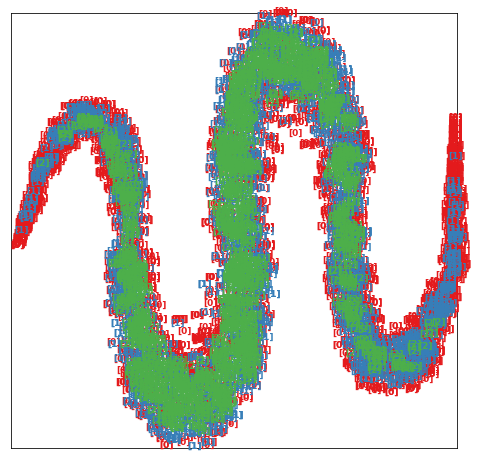

In [19]:
#单一故障分布
X_seen = x_train_1000
Y_seen = np.load('./data/train/y_train.npy')
n_samples, n_features = X_seen.shape

'''t-SNE'''
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X_seen)

print("Org data dimension is {}.  Embedded data dimension is {}".format(X_seen.shape[-1], X_tsne.shape[-1]))

'''嵌入空间可视化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(Y_seen[i]), color=plt.cm.Set1(Y_seen[i][0]),fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

In [19]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# 重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# 解码层，也就是生成器部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# 建立模型
vae = Model(x, x_decoded_mean)

# xent_loss是重构loss，kl_loss是KL loss
xent_loss = K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=-1)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# add_loss是新增的方法，用于更灵活地添加各种loss
vae.add_loss(vae_loss)
opt = keras.optimizers.adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
vae.compile(optimizer=opt)
vae.summary()

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 512)          1049088     input_5[0][0]                    
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 2)            1026        dense_21[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 2)            1026        dense_21[0][0]                   
___________________________________________________________________________________________

In [6]:
print(y_test.shape)

(14000, 1)


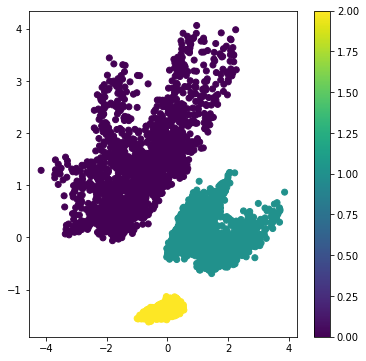

In [20]:
# 构建encoder，然后观察各个故障在隐空间的分布
encoder = Model(x, z_mean)

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [62]:
# 构建生成器
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [63]:
# 观察隐变量的两个维度变化是如何影响输出结果的
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [65]:
print(figure.shape)

(420, 420)


In [66]:
#用正态分布的分位数来构建隐变量对
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))



In [69]:
print(grid_y.shape)

(15,)


In [70]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

ValueError: cannot reshape array of size 2048 into shape (28,28)

In [ ]:
# latent_dim=64

In [1]:
#! -*- coding: utf-8 -*-

'''用Keras实现的VAE
   目前只保证支持Tensorflow后端
   改写自
   https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
'''

from __future__ import print_function

import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from sklearn import preprocessing


batch_size = 32
original_dim = 2048
latent_dim = 32 # 隐变量取2维只是为了方便后面画图
intermediate_dim = 512
epochs = 40


# 加载MNIST数据集
# (x_train, y_train_), (x_test, y_test_) = mnist.load_data()
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# 故障数据集
x_train = np.load(r".\data\train\x_train_2048.npy")
x_test = np.load(r".\data\train\x_train_2048.npy")
y_train = np.load(r".\data\train\y_train.npy")
y_test = np.load(r".\data\train\y_train.npy")
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

Using TensorFlow backend.


In [2]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# 重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# 解码层，也就是生成器部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# 建立模型
vae = Model(x, x_decoded_mean)

# xent_loss是重构loss，kl_loss是KL loss
xent_loss = K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=-1)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# add_loss是新增的方法，用于更灵活地添加各种loss
vae.add_loss(vae_loss)
opt = keras.optimizers.adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
vae.compile(optimizer=opt)
vae.summary()

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          1049088     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           16416       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           16416       dense_1[0][0]             

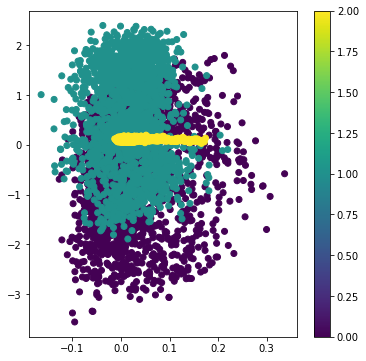

In [6]:
# 构建encoder，然后观察各个故障在隐空间的分布
encoder = Model(x, z_mean)

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 1], x_test_encoded[:, 31], c=y_test)
plt.colorbar()
plt.show()

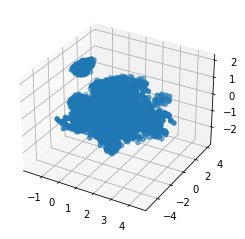

In [14]:
from mpl_toolkits.mplot3d import Axes3D
#定义坐标轴
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.scatter3D(x_test_encoded[:, 0],x_test_encoded[:, 1],x_test_encoded[:, 2], cmap='rainbow')  #绘制散点图

plt.show()